# Model Selection

In [37]:
from os import chdir
chdir('../')
%matplotlib inline
from lib import *

In [38]:
pwd

'/home/jovyan/work/projects'

### Load Data

In [7]:
#  data
features = pd.DataFrame(pd.read_pickle('./pickled/pickled_features'))
target = pd.DataFrame(pd.read_pickle('./pickled/pickled_target'))

# deskewed data
features_deskewed = pd.DataFrame(pd.read_pickle('./pickled/pickled_features_deskewed_scaled_w_Alpha'))
target_deskewed = pd.DataFrame(pd.read_pickle('./pickled/pickled_target_deskewed_scaled_w_Alpha'))


scaler_pickle = './pickled/pickle_scaler.sav'
pca_pickle='./pickled/pickle_pca.sav'
gs_knc_pickle = './pickled/pickle_gs_knc.sav'
scaler = joblib.load(scaler_pickle) 
pca = joblib.load(pca_pickle) 
gs_knc = joblib.load(pca_pickle) 

In [8]:
features.head(5)

,Id,MSSubClass,LotFrontage,LotArea,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,...,SaleType_ConLw,SaleType_New,SaleType_Oth,SaleType_WD,SaleCondition_Abnorml,SaleCondition_AdjLand,SaleCondition_Alloca,SaleCondition_Family,SaleCondition_Normal,SaleCondition_Partial
0,1.0,60.0,65.0,8450.0,2003.0,2003.0,196.0,706.0,0.0,150.0,...,0,0,0,1,0,0,0,0,1,0
1,2.0,20.0,80.0,9600.0,1976.0,1976.0,0.0,978.0,0.0,284.0,...,0,0,0,1,0,0,0,0,1,0
2,3.0,60.0,68.0,11250.0,2001.0,2002.0,162.0,486.0,0.0,434.0,...,0,0,0,1,0,0,0,0,1,0
3,4.0,70.0,60.0,9550.0,1915.0,1970.0,0.0,216.0,0.0,540.0,...,0,0,0,1,1,0,0,0,0,0
4,5.0,60.0,84.0,14260.0,2000.0,2000.0,350.0,655.0,0.0,490.0,...,0,0,0,1,0,0,0,0,1,0


In [9]:
features_deskewed.head()

,bsmtfinsf1,bsmtfinsf2,bsmtunfsf,enclosedporch,firstflrsf,grlivarea,lotarea,lotfrontage,lowqualfinsf,masvnrarea,...,totrmsabvgrd_10,totrmsabvgrd_11,totrmsabvgrd_12,utilities_AllPub,utilities_NoSeWa,yrsold_2006,yrsold_2007,yrsold_2008,yrsold_2009,yrsold_2010
id,,,,,,,,,,,,,,,,,,,,,
1,6.8320,0.6931,6.2461,0.6931,6.7310,7.5005,9.0677,4.7362,0.6931,5.2883,...,0,0,0,1,0,0,0,1,0,0
4,6.0799,0.6931,6.8090,5.6131,6.8491,7.5044,9.1872,4.6913,0.6931,0.6931,...,0,0,0,1,0,1,0,0,0,0
5,6.7754,0.6931,6.7523,0.6931,7.0273,7.7394,9.5806,4.8903,0.6931,5.8636,...,0,0,0,1,0,0,0,1,0,0
7,7.3715,0.6931,6.5265,0.6931,7.4242,7.4916,9.2404,4.8203,0.6931,5.2364,...,0,0,0,1,0,0,1,0,0,0
8,6.9847,3.5264,6.3665,5.4381,6.9930,7.6912,9.2689,4.7822,0.6931,5.4889,...,0,0,0,1,0,0,0,0,1,0


### (Fuction) Train-Test Split & Modeling

In [10]:
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier, KNeighborsRegressor
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor 
from sklearn.ensemble import RandomForestRegressor
from sklearn.dummy import DummyClassifier, DummyRegressor
from sklearn.decomposition import PCA
import pandas as pd
import numpy as np

def split(feature, target, test_size=.3, random_state = 42):
    X_train, X_test, y_train, y_test = train_test_split(feature,target,
                                                   test_size = test_size,
                                                   random_state = random_state)
    data_dict = {
        'X_train': X_train,
        'X_test': X_test,
        'y_train': y_train,
        'y_test': y_test,
    }
    return data_dict

def transform(data_dict, transformer = StandardScaler()):
    feature=data_dict.copy()
    feature['X_train']=transformer.fit_transform(feature['X_train'])
    feature['X_test']=transformer.transform(feature['X_test'])
    
    try:
        feature['transformer'].append(transformer)
    except:
        feature['transformer']=[transformer]
    return feature   

def fit_and_score(data_dict,model):
    d=data_dict.copy()
    model.fit(d['X_train'],d['y_train'])
    train_score=model.score(d['X_train'],d['y_train'])
    test_score=model.score(d['X_test'],d['y_test'])
    try:
        d['cv_results'] = model.cv_results_
        d['best_estimator'] = model.best_estimator_
    except:
        pass
    
    d['model']=model
    d['train_score']= train_score
    d['test_score']=test_score
    
    return d

### Benchmarking Model #1   KNearNeighbor

In [11]:
split_data = split(features, target)
scaled_data = transform(split_data)
pca_data=transform(scaled_data, PCA(n_components = 170))
#print(pca_data['transformer'])
knr_results = fit_and_score(scaled_data,KNeighborsRegressor())

print('Benchmark Train Score for KNN:', knr_results['train_score'])
print('Benchmark Test Score for KNN:', knr_results['test_score'])


print('\033[1;35;30m Model:  \n', knr_results['model'])

Benchmark Train Score for KNN: 0.828761740875
Benchmark Test Score for KNN: 0.761672909649
 Model:  
 KNeighborsRegressor(algorithm='auto', leaf_size=30, metric='minkowski',
          metric_params=None, n_jobs=1, n_neighbors=5, p=2,
          weights='uniform')


### Benchmarking Model #2 Decision Tree Regressor

In [12]:
split_data = split(features, target)
scaled_data =transform(split_data)
dtr_results = fit_and_score(scaled_data,DecisionTreeRegressor())
print('Benchmark Train Score for DTR:', dtr_results['train_score'])
print('Benchmark Test Score for DTR:', dtr_results['test_score'])
print('\033[1;35;30m Model:  \n', dtr_results['model'])

Benchmark Train Score for DTR: 1.0
Benchmark Test Score for DTR: 0.718310310071
 Model:  
 DecisionTreeRegressor(criterion='mse', max_depth=None, max_features=None,
           max_leaf_nodes=None, min_impurity_split=1e-07,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, presort=False, random_state=None,
           splitter='best')


### Benchmarking Model #3 Random Forest Regressor

In [22]:
split_data = split(features, np.ravel(target))
scaled_data =transform(split_data)
rfr_results = fit_and_score(scaled_data,RandomForestRegressor())
print('Benchmark Train Score for RFR:', rfr_results['train_score'])
print('Benchmark Test Score for RFR:', rfr_results['test_score'])
print('\033[1;35;30m Model:  \n', rfr_results['model'])

Benchmark Train Score for RFR: 0.962436315075
Benchmark Test Score for RFR: 0.865780147016
 Model:  
 RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_split=1e-07, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           n_estimators=10, n_jobs=1, oob_score=False, random_state=None,
           verbose=0, warm_start=False)


### Prediction #1 Scaled GridSearch KNN Regressor

In [32]:
split_data = split(features, target)
scaled_data = transform(split_data)
knr_params={
    'n_neighbors': list(range(1,21,1))
}
gs_knr=GridSearchCV(KNeighborsRegressor(),param_grid=knr_params,cv=5,n_jobs=-1)
gs_knr_results = fit_and_score(scaled_data,gs_knr)
print('Benchmark Train_Score for KNN:', knr_results['train_score'])
print('Benchmark Test_Score for KNN:', knr_results['test_score'])
print('Train_Score:', gs_knr_results['train_score'])
print('Test_Score:', gs_knr_results['test_score'])

Benchmark Train_Score for KNN: 0.828761740875
Benchmark Test_Score for KNN: 0.761672909649
Train_Score: 0.916286334084
Test_Score: 0.764273378403


/opt/conda/lib/python3.5/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


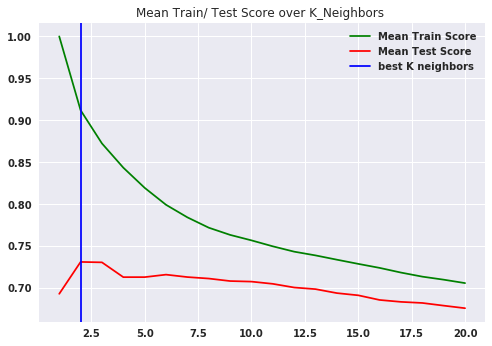

In [33]:
g = pd.DataFrame(gs_knr_results['cv_results'])
plt.plot(g['param_n_neighbors'],g['mean_train_score'], c='g',label='Mean Train Score')
plt.plot(g['param_n_neighbors'],g['mean_test_score'], c='r',label='Mean Test Score')
plt.axvline(gs_knr_results['best_estimator'].n_neighbors,c='b',label='best K neighbors')
plt.title('Mean Train/ Test Score over K_Neighbors ')
plt.legend()

### Prediction #2  Scaled GridSearch Decision Tree Regressor

In [34]:
split_data = split(features, target)
scaled_data = transform(split_data)

dtr_params={
    'max_depth':list(range(3,15,1)),
     'min_samples_leaf':[6,12,18,24]
}
gs_dtr=GridSearchCV(DecisionTreeRegressor(),param_grid=dtr_params,cv=5,n_jobs = -1)
gs_dtr_results = fit_and_score(scaled_data, gs_dtr)
print('Benchmark Train_Score for DTR:', dtr_results['train_score'])
print('Benchmark Test_Score for DTR:', dtr_results['test_score'])
print('Train_Score:', gs_dtr_results['train_score'])
print('Test_Score:', gs_dtr_results['test_score'])

Benchmark Train_Score for DTR: 1.0
Benchmark Test_Score for DTR: 0.718310310071
Train_Score: 0.866413152629
Test_Score: 0.818412256854


/opt/conda/lib/python3.5/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


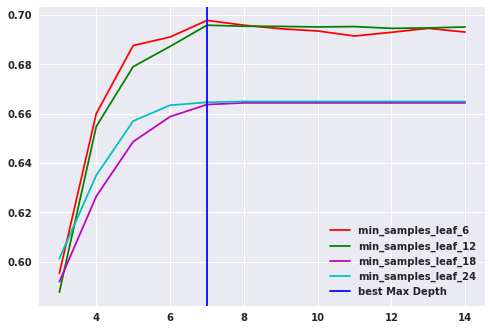

In [35]:
g = pd.DataFrame(gs_dtr_results['cv_results'])
min_samples_leaf_6 = g[g['param_min_samples_leaf'] == 6][['param_max_depth','mean_test_score']]
min_samples_leaf_12 = g[g['param_min_samples_leaf'] == 12][['param_max_depth','mean_test_score']]
min_samples_leaf_18 = g[g['param_min_samples_leaf'] == 18][['param_max_depth','mean_test_score']]
min_samples_leaf_24 = g[g['param_min_samples_leaf'] == 24][['param_max_depth','mean_test_score']]
plt.plot(min_samples_leaf_6 .values[:,0],min_samples_leaf_6 .values[:,1], c='r',label='min_samples_leaf_6 ')
plt.plot(min_samples_leaf_12.values[:,0],min_samples_leaf_12.values[:,1], c='g',label='min_samples_leaf_12')
plt.plot(min_samples_leaf_18.values[:,0],min_samples_leaf_18.values[:,1], c='m',label='min_samples_leaf_18')
plt.plot(min_samples_leaf_24.values[:,0],min_samples_leaf_24.values[:,1], c='c',label='min_samples_leaf_24')
plt.axvline(gs_dtr_results['best_estimator'].max_depth,c='b',label='best Max Depth')
plt.legend()

### Prediction #3 Scaled GridSearch RandomForest Regressor

In [41]:
split_data = split(features, np.ravel(target))
scaled_data = transform(split_data)

rfr_params={
    'n_estimators': list(range(10,40,2))   
}
gs_rfr= GridSearchCV(RandomForestRegressor(),param_grid=rfr_params,cv=5,n_jobs=-1)
gs_rfr_results = fit_and_score(scaled_data,gs_rfr)
print('Benchmark Train_Score for RFR:', rfr_results['train_score'])
print('Benchmark Test_Score for RFR:', rfr_results['test_score'])
print('Train_Score:', gs_rfr_results['train_score'])
print('Test_Score:', gs_rfr_results['test_score'])
print('\033[1;36;30m Best Estimater for GS_RFR:  \n', gs_rfr_results['best_estimator'])
#print('\033[1;35;30m Model:  \n', gs_rfr_results['model'])

Benchmark Train_Score for RFR: 0.962436315075
Benchmark Test_Score for RFR: 0.865780147016
Train_Score: 0.971507736499
Test_Score: 0.884207902205
 Best Estimater for GS_RFR:  
 RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_split=1e-07, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           n_estimators=24, n_jobs=1, oob_score=False, random_state=None,
           verbose=0, warm_start=False)


In [42]:
from sklearn.externals import joblib
joblib.dump(gs_dtr_results['model'], 'gs_rfr')

['gs_rfr']

/opt/conda/lib/python3.5/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


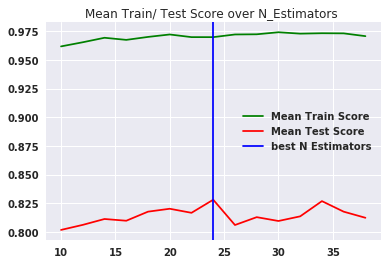

In [46]:
g = pd.DataFrame(gs_rfr_results['cv_results'])
plt.plot(g['param_n_estimators'],g['mean_train_score'], c='g',label='Mean Train Score')
plt.plot(g['param_n_estimators'],g['mean_test_score'], c='r',label='Mean Test Score')
plt.axvline(gs_rfr_results['best_estimator'].n_estimators,c='b',label='best N Estimators')
plt.title('Mean Train/ Test Score over N_Estimators ')
plt.legend()

In [47]:
variable_model = joblib.load('gs_rfr')

In [48]:
variable_model

GridSearchCV(cv=5, error_score='raise',
       estimator=DecisionTreeRegressor(criterion='mse', max_depth=None, max_features=None,
           max_leaf_nodes=None, min_impurity_split=1e-07,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, presort=False, random_state=None,
           splitter='best'),
       fit_params={}, iid=True, n_jobs=-1,
       param_grid={'max_depth': [3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14], 'min_samples_leaf': [6, 12, 18, 24]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring=None, verbose=0)